In [23]:
# basic import
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, precision_recall_curve, auc, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay,classification_report
from imblearn.over_sampling import SMOTE


## **EXPLORATORY DATA ANALYSIS**

In [146]:
df = pd.read_csv('/content/drive/MyDrive/data science/loan_data.csv')


In [13]:
df.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB



*   one object column that would be one hot encoded



In [4]:
df.describe()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
count,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9.578000e+03,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000
mean,0.804970,0.122640,319.089413,10.932117,12.606679,710.846314,4560.767197,1.691396e+04,46.799236,1.577469,0.163708,0.062122,0.160054
std,0.396245,0.026847,207.071301,0.614813,6.883970,37.970537,2496.930377,3.375619e+04,29.014417,2.200245,0.546215,0.262126,0.366676
min,0.000000,0.060000,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.103900,163.770000,10.558414,7.212500,682.000000,2820.000000,3.187000e+03,22.600000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.122100,268.950000,10.928884,12.665000,707.000000,4139.958333,8.596000e+03,46.300000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.140700,432.762500,11.291293,17.950000,737.000000,5730.000000,1.824950e+04,70.900000,2.000000,0.000000,0.000000,0.000000
max,1.000000,0.216400,940.140000,14.528354,29.960000,827.000000,17639.958330,1.207359e+06,119.000000,33.000000,13.000000,5.000000,1.000000


We have large range of values and normalization seems like a good move here to increase accuracy in our predictions

In [5]:
df.duplicated().sum() # Check for duplicates

0

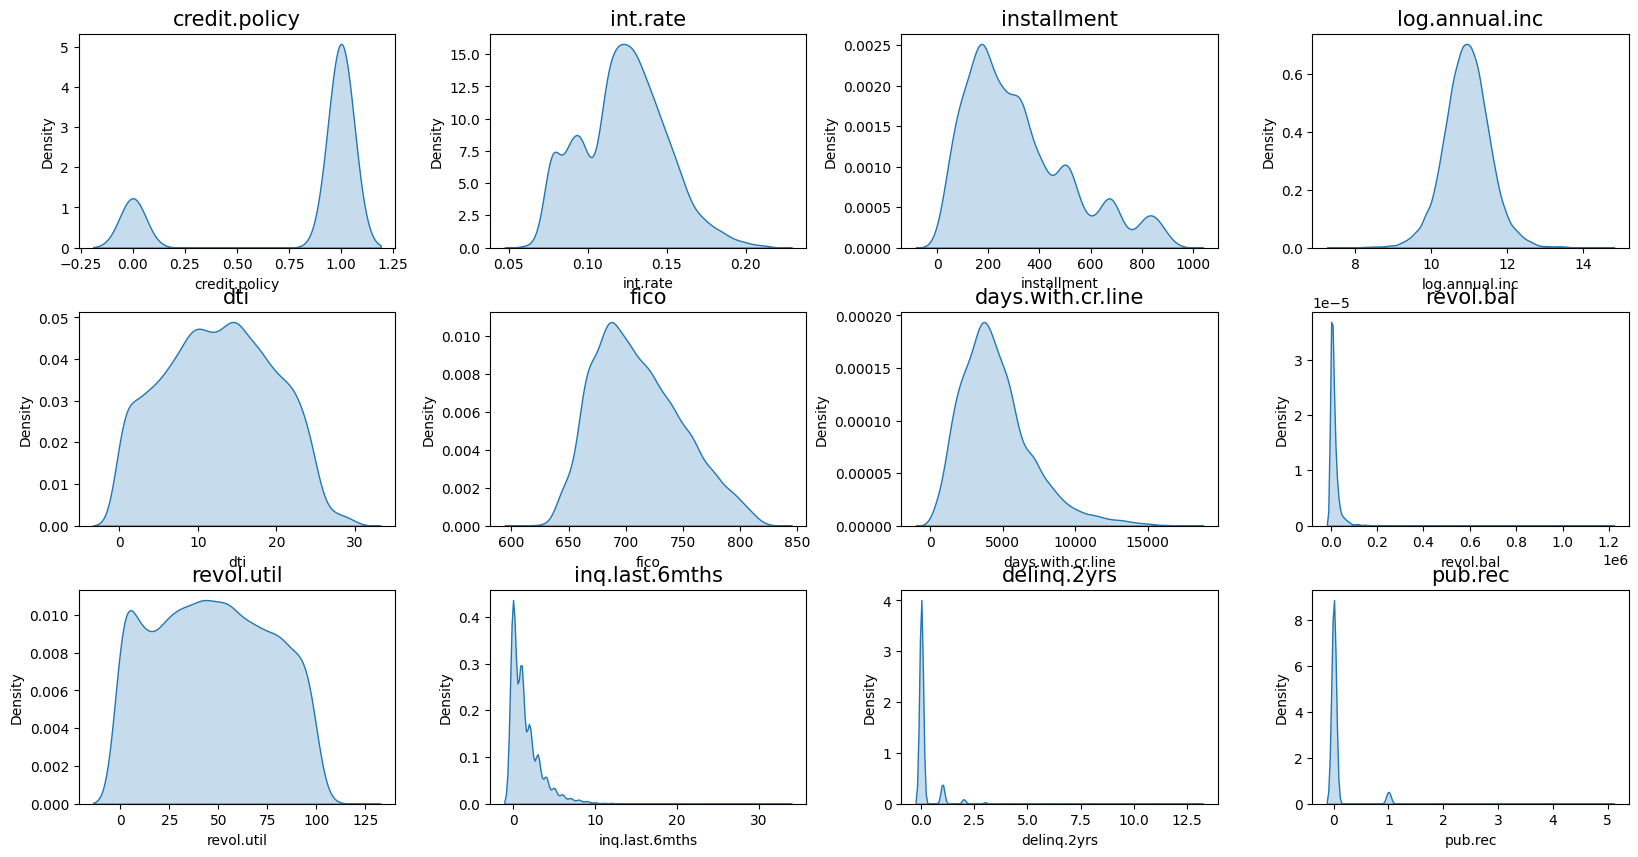

In [6]:
num = df.select_dtypes(exclude=['object']) # only integers and floats included

# Plot data distribution
fig, axes = plt.subplots(3, 4, figsize=(20, 10))
sns.set_style('dark')
sns.set_palette('Blues_r')

for ax, col in zip(axes.flatten(), num.columns):
    sns.kdeplot(num[col], ax=ax, fill=True)
    ax.set_title(col, fontsize=15)

plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

Here In the Kernel Density plot  we notice that, in our class we have large class imbalance in our two groups, 1 (Fully paid) and 0 (not paid)

In [7]:
Q1 = num.quantile(0.25)
Q3 = num.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = num[(num < lower_bound) | (num > upper_bound)]

print(
    f"The total number of outliers is: {outliers.count().sum()}\n\nNumber of outliers in each columns:\n{outliers.count()}")

The total number of outliers is: 7215

Number of outliers in each columns:
credit.policy        1868
int.rate               51
installment           236
log.annual.inc        238
dti                     0
fico                    6
days.with.cr.line     346
revol.bal             780
revol.util              0
inq.last.6mths        478
delinq.2yrs          1120
pub.rec               559
not.fully.paid       1533
dtype: int64


decided to leave outliers since most loans vary and have lots of outliers

In [124]:
# Target frequency
df['not.fully.paid'].value_counts(normalize = True)

0    0.839946
1    0.160054
Name: not.fully.paid, dtype: float64

We confirm a class imbalance here something we must deal with using statistical methods

## Data preprocessing step

In [147]:
# Feature and target variable create classic classification problem
df = pd.get_dummies(df, columns = ['purpose'], drop_first= True )
X = df.drop('not.fully.paid', axis=1)
y = df['not.fully.paid']

smote = SMOTE(sampling_strategy='minority') # use oversampling technique for class imbalance

X, y = smote.fit_resample(X, y)

print(y.value_counts())

seed = 123
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, stratify = y , random_state = seed)

0    8045
1    8045
Name: not.fully.paid, dtype: int64


In [190]:
from imblearn.pipeline import make_pipeline as make_imb_pipeline
import xgboost as xgb

num_selector = make_column_selector(dtype_exclude='object')
num_cols = num_selector(X)

# Preprocessing numeric columns
num_preprocessor = StandardScaler()

# Create imbalanced pipelines with SMOTE oversampling
pipelines = {
    'K-Neighbors Classifier': make_imb_pipeline(num_preprocessor, KNeighborsClassifier(n_neighbors=13)),
    'Logistic Regression': make_imb_pipeline(num_preprocessor, LogisticRegression(random_state=seed)),
    'Random Forest Classifier': make_imb_pipeline(num_preprocessor, RandomForestClassifier(random_state=seed)),
    'Xgboost Classifier': make_imb_pipeline(num_preprocessor, xgb.XGBClassifier(objective = 'binary:logistic',n_estimators = 10,learning_rate=0.02, seed = 123)),
}


In [173]:
def metrics_from_pipes(pipes_dict):
    '''
    This function takes as input a dictionary of ML pipilines  and
    returns a table all the train and test metrics for
    each model in the dictionary
    '''
    train_accs = []
    train_f1s = []
    train_roc_aucs = []
    train_pr_aucs = []
    train_precs = []
    train_recs = []
    train_specs = []
    train_fprs_list = []
    train_fnrs_list = []

    test_accs = []
    test_f1s = []
    test_roc_aucs = []
    test_pr_aucs = []
    test_precs = []
    test_recs = []
    test_specs = []
    test_fprs_list = []
    test_fnrs_list = []

    for name, pipeline in pipes_dict.items():
        pipeline.fit(X_train, y_train)
        y_pred_test = pipeline.predict(X_test)
        y_pred_train = pipeline.predict(X_train)

        y_probs_test = pipeline.predict_proba(X_test)[:, 1]
        y_probs_train = pipeline.predict_proba(X_train)[:, 1]

        train_precisions, train_recalls, threshold = precision_recall_curve(y_train, y_probs_train)
        test_precisions, test_recalls, threshold = precision_recall_curve(y_test, y_probs_test)

        tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train, y_pred_train).ravel()
        tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_pred_test).ravel()

        train_accs.append(accuracy_score(y_train, y_pred_train))
        train_f1s.append(f1_score(y_train, y_pred_train))
        train_roc_aucs.append(roc_auc_score(y_train, y_probs_train))
        train_pr_aucs.append(auc(train_recalls, train_precisions))
        train_precs.append(precision_score(y_train, y_pred_train))
        train_recs.append(recall_score(y_train, y_pred_train))
        train_specs.append(tn_train / (tn_train + fp_train))
        train_fprs_list.append(fp_train / (fp_train + tn_train))
        train_fnrs_list.append(fn_train / (fn_train + tp_train))

        test_accs.append(accuracy_score(y_test, y_pred_test))
        test_f1s.append(f1_score(y_test, y_pred_test))
        test_roc_aucs.append(roc_auc_score(y_test, y_probs_test))
        test_pr_aucs.append(auc(test_recalls, test_precisions))
        test_precs.append(precision_score(y_test, y_pred_test))
        test_recs.append(recall_score(y_test, y_pred_test))
        test_specs.append(tn_test / (tn_test + fp_test))
        test_fprs_list.append(fp_test / (fp_test + tn_test))
        test_fnrs_list.append(fn_test / (fn_test + tp_test))

    # aggregate the performance metric lists into seperate dataframes
    train_metrics = pd.DataFrame(
        {'model': pipes_dict.keys(),
         'accuracy': train_accs,
         'f1_score': train_f1s,
         'roc_auc': train_roc_aucs,
         'pr_auc': train_pr_aucs,
         'precision': train_precs,
         'recall': train_recs,
         'specificity': train_specs,
         'false_positive_rate': train_fprs_list,
         'false_negative_rate': train_fnrs_list})

    test_metrics = pd.DataFrame(
        {'model': pipes_dict.keys(),
         'accuracy': test_accs,
         'f1_score': test_f1s,
         'roc_auc': test_roc_aucs,
         'pr_auc': test_pr_aucs,
         'precision': test_precs,
         'recall': test_recs,
         'specificity': test_specs,
         'false_positive_rate': test_fprs_list,
         'false_negative_rate': test_fnrs_list})

    # Merging metrics from train and test set
    train_test_metrics = train_metrics.merge(test_metrics,
                                             on='model',
                                             how='left',
                                             suffixes=('_train', '_test'))

    # Sorting coulmns
    train_test_metrics = train_test_metrics.reindex(columns=['model',
                                                             'accuracy_train',
                                                             'accuracy_test',
                                                             'f1_score_train',
                                                             'f1_score_test',
                                                             'roc_auc_train',
                                                             'roc_auc_test',
                                                             'pr_auc_train',
                                                             'pr_auc_test',
                                                             'precision_train',
                                                             'precision_test',
                                                             'recall_train',
                                                             'recall_test',
                                                             'specificity_train',
                                                             'specificity_test',
                                                             'false_positive_rate_train',
                                                             'false_positive_rate_test',
                                                             'false_negative_rate_train',
                                                             'false_negative_rate_test'])

    return train_test_metrics.set_index('model').transpose()


In [191]:
metrics_table = metrics_from_pipes(pipelines)


In [192]:
metrics_table.style.background_gradient(cmap='Blues')


model,K-Neighbors Classifier,Logistic Regression,Random Forest Classifier,Xgboost Classifier
accuracy_train,0.803605,0.759711,1.000000,0.758856
accuracy_test,0.769111,0.762585,0.853636,0.742697
f1_score_train,0.809236,0.759356,1.000000,0.767734
f1_score_test,0.776407,0.761548,0.848211,0.752836
roc_auc_train,0.897703,0.831153,1.000000,0.839368
roc_auc_test,0.851562,0.829072,0.919224,0.818680
pr_auc_train,0.908008,0.830327,1.000000,0.843400
pr_auc_test,0.863094,0.835736,0.931276,0.826510
precision_train,0.786678,0.760480,1.000000,0.740473
precision_test,0.752625,0.764890,0.880857,0.724296


## Hyper Parameter Optimization


In [194]:
#Create a dictionary if hyperparameters
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

#Define a cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

#Instantiate a GridSearchCV object
grid_xg= GridSearchCV(estimator=pipelines['Xgboost Classifier'],
                            param_grid=params,
                            scoring='roc_auc',
                            cv=cv,
                            n_jobs=-1)

#Fit the GridSearchCV object
grid_xg.fit(X_train, y_train)


ValueError: Invalid parameter 'colsample_bytree' for estimator Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.02,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=10, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))]). Valid parameters are: ['memory', 'steps', 'verbose'].